### Secret Manager Function

In [9]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

### Connect to Database

In [10]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

## Use AI to Assistant Data Analytics

In [11]:
! pip install jupyter-ai-magics[all] -q

In [12]:
import warnings
warnings.simplefilter('ignore')

In [13]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

In [14]:
%load_ext jupyter_ai_magics

The jupyter_ai_magics extension is already loaded. To reload it, use:
  %reload_ext jupyter_ai_magics


# Q1 – Population Growth Rate

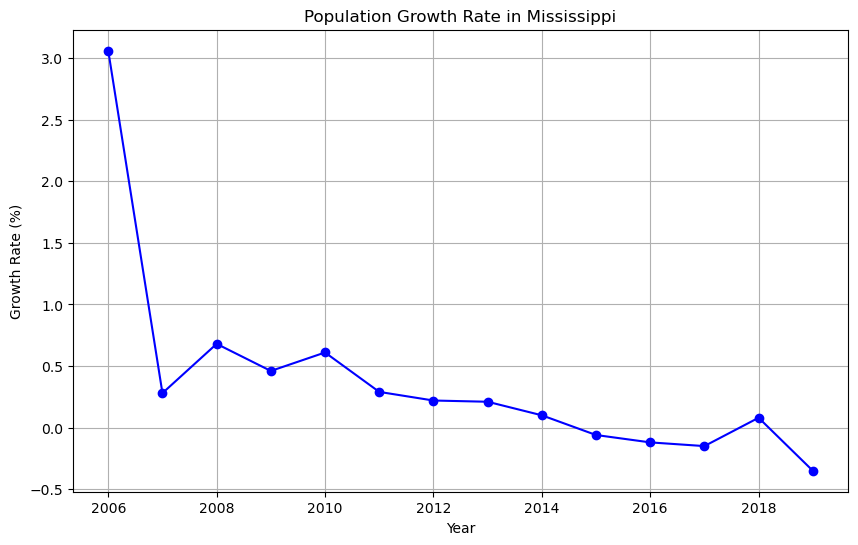

In [17]:
import pandas as pd

query = """
SELECT p.year,
       p.pop,
       ROUND(100.0 * (p.pop - LAG(p.pop) OVER (ORDER BY p.year)) / LAG(p.pop) OVER (ORDER BY p.year), 2) 
       AS growth_rate
FROM population p
JOIN name n ON p.fips = n.fips
WHERE n.name = 'Mississippi'
ORDER BY p.year;
"""

df = pd.read_sql(query, conn)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(df['year'], df['growth_rate'], marker='o', color="blue")
plt.title("Population Growth Rate in Mississippi")
plt.xlabel("Year")
plt.ylabel("Growth Rate (%)")
plt.grid(True)
plt.show()


Explanation: The Population growth rate in Mississippi has significantly decreased over the years. 

# Q2 – Income and Population Relationship (Mississippi)

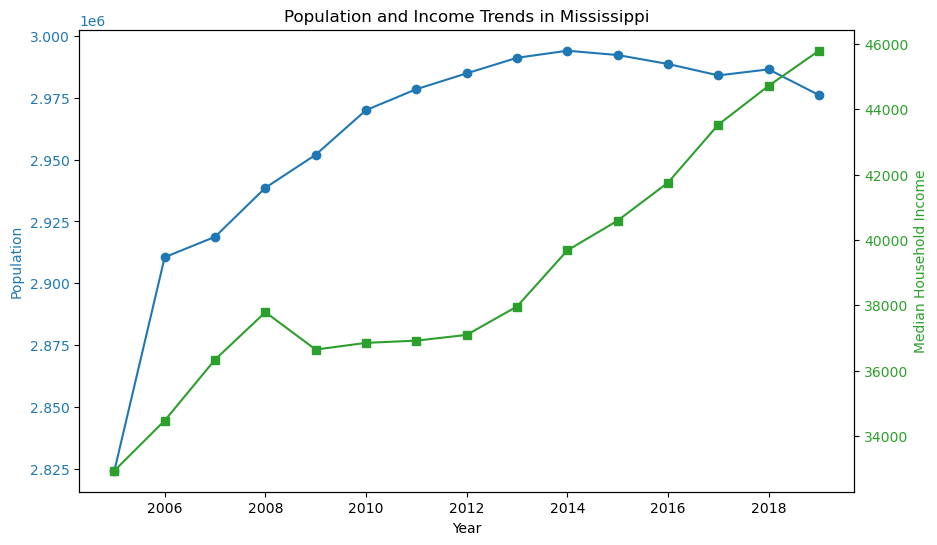

In [18]:
query = """
SELECT i.year, i.income, p.pop
FROM income i
JOIN population p 
  ON i.fips = p.fips AND i.year = p.year
JOIN name n 
  ON i.fips = n.fips
WHERE n.name = 'Mississippi'
ORDER BY i.year;
"""

df = pd.read_sql(query, conn)

fig, ax1 = plt.subplots(figsize=(10,6))

ax1.set_xlabel("Year")
ax1.set_ylabel("Population", color="tab:blue")
ax1.plot(df['year'], df['pop'], color="tab:blue", marker="o")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Median Household Income", color="tab:green")
ax2.plot(df['year'], df['income'], color="tab:green", marker="s")
ax2.tick_params(axis="y", labelcolor="tab:green")

plt.title("Population and Income Trends in Mississippi")
plt.show()


Explanation: There is a positive trend with population and income in Mississippi, reaching about $46,000-44,000 median household income. 

# Q3 – Mississippi Student-Defined Question

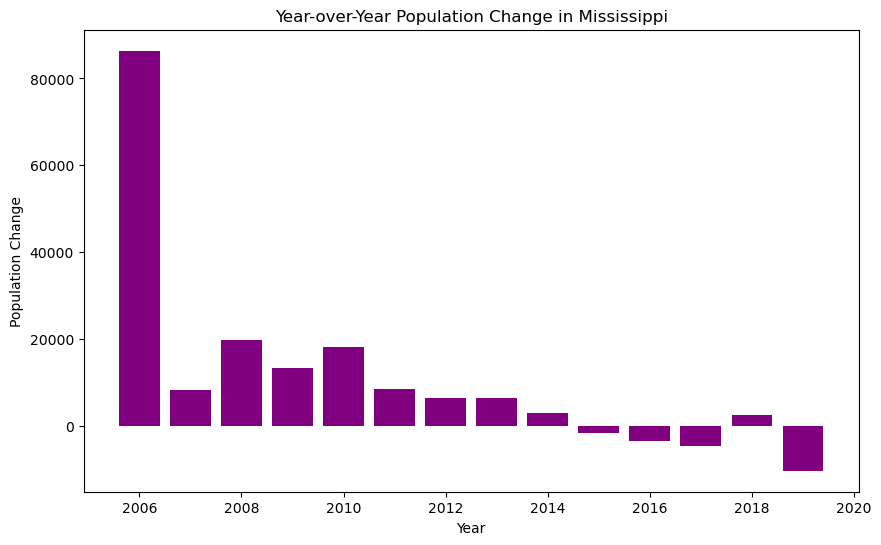

In [19]:
query = """
SELECT year, 
       pop - LAG(pop) OVER (ORDER BY year) AS pop_change
FROM population p
JOIN name n ON p.fips = n.fips
WHERE n.name = 'Mississippi'
ORDER BY year;
"""

df = pd.read_sql(query, conn)

plt.figure(figsize=(10,6))
plt.bar(df['year'], df['pop_change'], color="purple")
plt.title("Year-over-Year Population Change in Mississippi")
plt.xlabel("Year")
plt.ylabel("Population Change")
plt.show()


Explanation:There is a spike of population change in 2006 but significantly decreases throughtout the years until it takes a below zero population change until 2018 and it decreases again.